#Loading Datasets

In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00


In [3]:
import random

In [4]:
from tqdm import tqdm
from datasets import load_dataset

def load_cnn_dailymail_dataset(split="train", num_examples=None):
    dataset = load_dataset("cnn_dailymail", "3.0.0", split=split)
    if num_examples:
        dataset = dataset.select(list(range(num_examples)))
    return dataset

# Assuming you have a similar function to load the Tatoeba dataset
def load_tatoeba_dataset(num_examples=None):
    dataset = load_dataset("tatoeba",lang1="en", lang2="hi", split="train")  # Use the appropriate dataset version and split here
    if num_examples:
        dataset = dataset.select(list(range(num_examples)))
    return dataset

# Load the datasets with a limited number of examples
num_examples = 10949  # Choose the number of examples you want
summarization_dataset = load_cnn_dailymail_dataset(split="train", num_examples=num_examples)
translation_dataset = load_tatoeba_dataset(num_examples=num_examples)

# Merging based on length similarity

merged_dataset = []
used_indices = set()  # To keep track of already used indices from the translation dataset

for summary in tqdm(summarization_dataset, desc="Merging datasets", unit="example"):
    article = summary["article"]
    summary_text = summary["highlights"]

    # Randomly sample from translation dataset without replacement
    available_indices = set(range(len(translation_dataset))) - used_indices
    if not available_indices:
        break  # If all sentences have been used, exit loop

    random_index = random.choice(list(available_indices))
    used_indices.add(random_index)

    english_sentence = translation_dataset[random_index]["translation"]["en"]
    hindi_translation = translation_dataset[random_index]["translation"]["hi"]

    merged_dataset.append({
        "article": article,
        "summary_en": summary_text,
        "sentence_en": english_sentence,
        "sentence_hi": hindi_translation
    })




Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Merging datasets: 100%|██████████| 10949/10949 [00:13<00:00, 836.96example/s] 


In [5]:
#Save the merged dataset to CSV file
import pandas as pd

# Convert to pandas DataFrame
df = pd.DataFrame(merged_dataset)
# Save to CSV in Colab's temporary storage
df.to_csv('/content/merged_dataset.csv', index=False)


#Data Preprocessing

In [6]:
!pip install langdetect
!pip install nltk

import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=1e206d91b6af23129092e8597f05e4f1acb34734b9e7e45a1e62af0063e445a3
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import re
from nltk.tokenize import word_tokenize
from langdetect import detect

# Function to clean text data
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove extra whitespaces
    text = ' '.join(text.split())
    # Remove special characters
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

# Function to identify language
def identify_language(text):
    try:
        language = detect(text)
        return language
    except:
        return "Language identification failed"

# Preprocess the data
for entry in merged_dataset:
    # Clean article and summary
    entry['article'] = clean_text(entry['article'])
    entry['summary_en'] = clean_text(entry['summary_en'])

    # Tokenize article and summary
    entry['article_tokens'] = word_tokenize(entry['article'])
    entry['summary_en_tokens'] = word_tokenize(entry['summary_en'])

    # Identify source language for article
    entry['source_lang'] = identify_language(entry['article'])

    # Assuming Hindi as the target language for translation
    entry['target_lang'] = 'hi'

# Show an example
print(merged_dataset[0])


{'article': 'LONDON England Reuters  Harry Potter star Daniel Radcliffe gains access to a reported 20 million 411 million fortune as he turns 18 on Monday but he insists the money wont cast a spell on him Daniel Radcliffe as Harry Potter in Harry Potter and the Order of the Phoenix To the disappointment of gossip columnists around the world the young actor says he has no plans to fritter his cash away on fast cars drink and celebrity parties I dont plan to be one of those people who as soon as they turn 18 suddenly buy themselves a massive sports car collection or something similar he told an Australian interviewer earlier this month I dont think Ill be particularly extravagant The things I like buying are things that cost about 10 pounds  books and CDs and DVDs At 18 Radcliffe will be able to gamble in a casino buy a drink in a pub or see the horror film Hostel Part II currently six places below his number one movie on the UK box office chart Details of how hell mark his landmark birt

##Data Visualization

In [9]:
!pip install matplotlib wordcloud seaborn

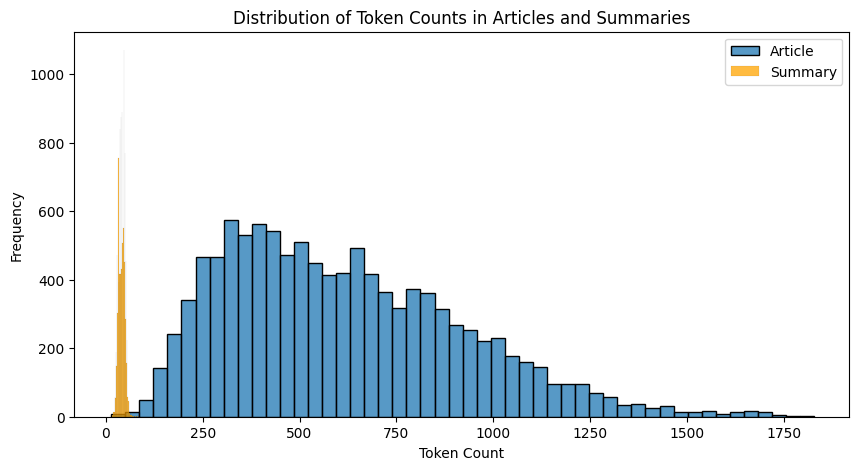

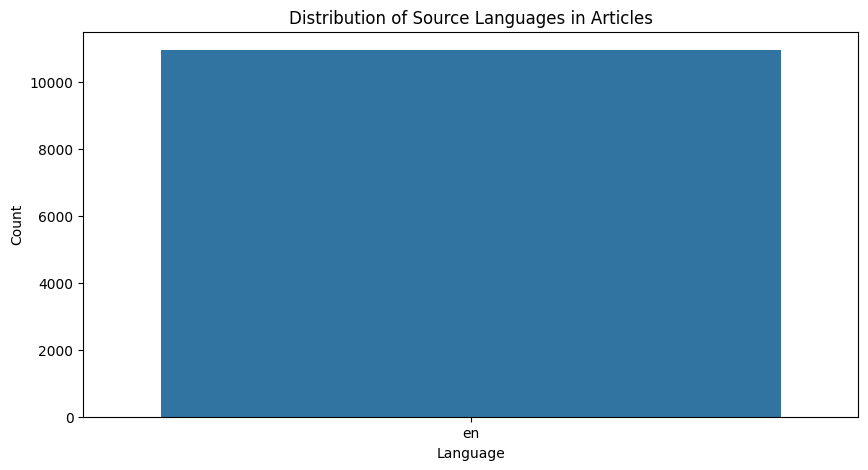

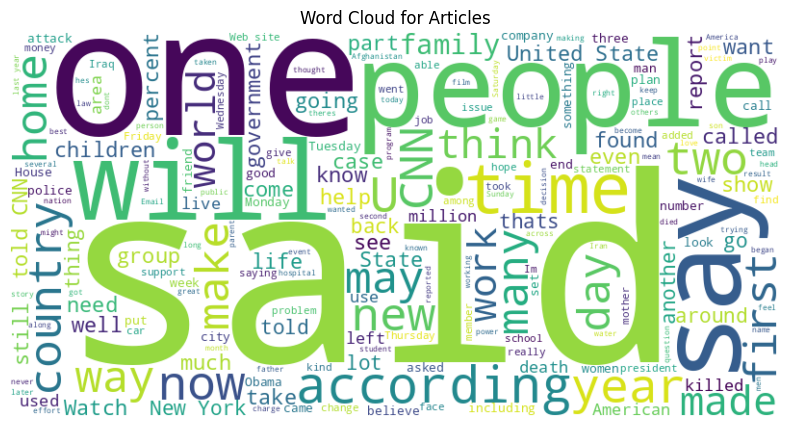

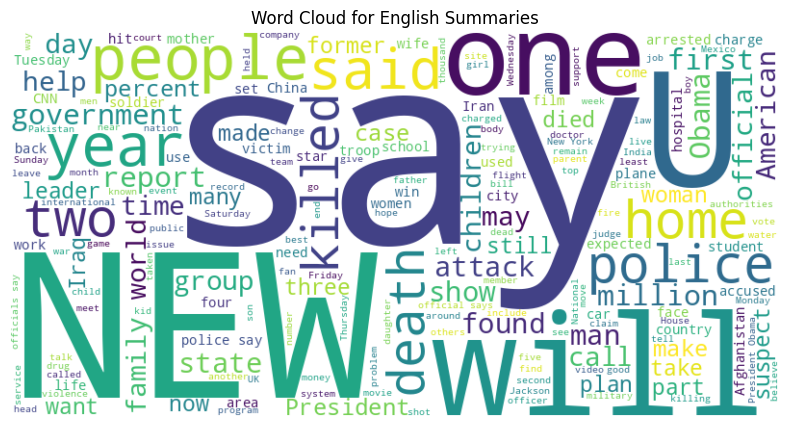

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# 1. Token Count Distribution
article_lengths = [len(entry['article_tokens']) for entry in merged_dataset]
summary_lengths = [len(entry['summary_en_tokens']) for entry in merged_dataset]

plt.figure(figsize=(10, 5))
sns.histplot(article_lengths, bins=50, kde=False, label='Article')
sns.histplot(summary_lengths, bins=50, kde=False, label='Summary', color='orange')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts in Articles and Summaries')
plt.legend()
plt.show()

print()

# 2. Language Distribution (if applicable)
source_languages = [entry['source_lang'] for entry in merged_dataset if 'source_lang' in entry]
plt.figure(figsize=(10, 5))
sns.countplot(x=source_languages)
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Source Languages in Articles')
plt.show()

print()

# 3. Word Cloud for Articles
text = " ".join([" ".join(entry['article_tokens']) for entry in merged_dataset])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Articles')
plt.show()

print()

# 3. Word Cloud for Summaries
text = " ".join([" ".join(entry['summary_en_tokens']) for entry in merged_dataset])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for English Summaries')
plt.show()


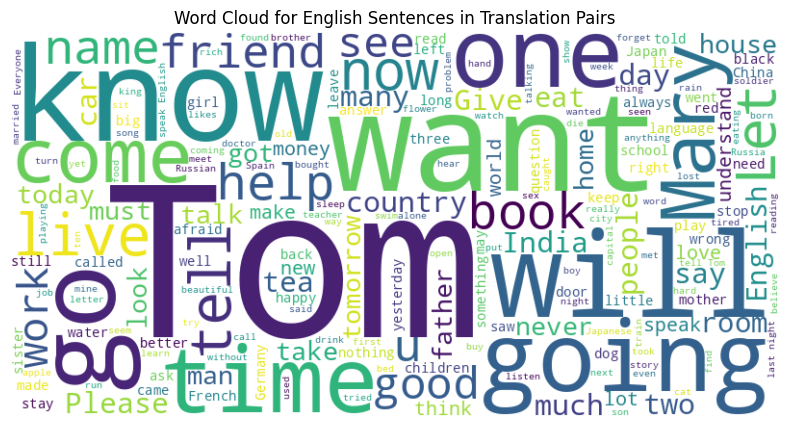

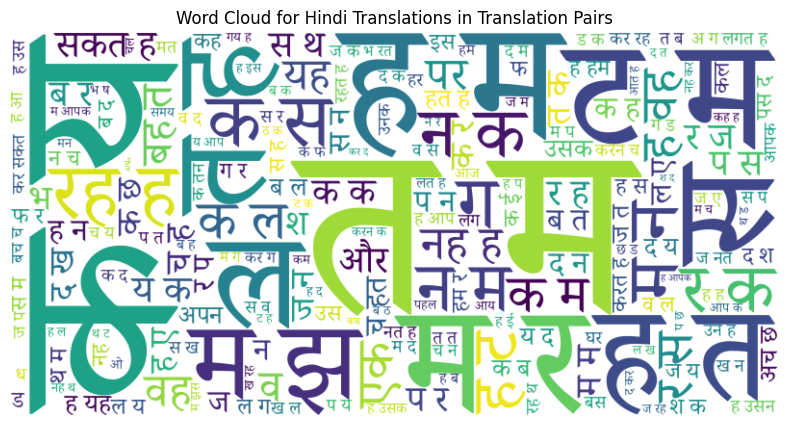

In [11]:
# 4. Word Cloud for English Sentences in Translation Pairs
english_sentences = [entry['sentence_en'] for entry in merged_dataset if 'sentence_en' in entry]
text_en = " ".join(english_sentences)
wordcloud_en = WordCloud(width=800, height=400, background_color='white').generate(text_en)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for English Sentences in Translation Pairs')
plt.show()

# Path to your Hindi font .ttf file
hindi_font_path = 'NotoSerifDevanagari-VariableFont_wdth,wght.ttf'
print()

# 5. Word Cloud for Hindi Translations in Translation Pairs
hindi_translations = [entry['sentence_hi'] for entry in merged_dataset if 'sentence_hi' in entry]
text_hi = " ".join(hindi_translations)
wordcloud_hi = WordCloud(width=800, height=400, background_color='white', font_path='NotoSerifDevanagari-VariableFont_wdth,wght.ttf').generate(text_hi)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_hi, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hindi Translations in Translation Pairs')
plt.show()

##Model Development

In [12]:
!pip install datasets transformers pandas nltk
!pip install transformers[torch]
!pip install accelerate -U
!pip install accelerate>=0.20.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.0 MB/s eta 0:00:00


In [13]:
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
import nltk

In [14]:
from datasets import Dataset, DatasetDict
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments

# Select the first 1200 items from merged_dataset
selected_dataset = merged_dataset[:2000]  # Adjust the number as needed

# Create a dictionary with keys "article" and "summary_en"
dataset_dict = {
    "article": [item["article"] for item in selected_dataset],
    "summary_en": [item["summary_en"] for item in selected_dataset],
}

# Convert dataset_dict to a Hugging Face Dataset
dataset = Dataset.from_dict(dataset_dict)

# Splitting the dataset into training and validation sets
train_test_split = dataset.train_test_split(test_size=0.1)  # Adjust the test_size as needed

# Load tokenizer and model
summarization_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
summarization_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Preprocess the data
def preprocess_function(examples):
    inputs = examples["article"]
    summaries = examples["summary_en"]

    # Ensure that all entries are strings
    inputs = [str(article) if article is not None else "" for article in inputs]
    summaries = [str(summary) if summary is not None else "" for summary in summaries]

    # Tokenize inputs and summaries with padding to max_length
    model_inputs = summarization_tokenizer(inputs, max_length=1024, padding="max_length", truncation=True)

    # Since the tokenizer's batch_encode_plus method automatically manages padding and truncation,
    # we use it here to process the labels as well.
    labels = summarization_tokenizer(summaries, max_length=128, padding="max_length", truncation=True)

    # Add labels to model_inputs
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# Apply preprocessing to each split
tokenized_datasets = DatasetDict({
    'train': train_test_split['train'].map(preprocess_function, batched=True),
    'validation': train_test_split['test'].map(preprocess_function, batched=True)
})

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    fp16=False  # Set this to False if you're not using a compatible GPU
)

# Initialize Trainer
trainer = Trainer(
    model=summarization_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

# Train the model
trainer.train()



vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss
500,0.838700
1000,0.406300


TrainOutput(global_step=1350, training_loss=0.5391301190411603, metrics={'train_runtime': 2585.7082, 'train_samples_per_second': 2.088, 'train_steps_per_second': 0.522, 'total_flos': 1.17023648514048e+16, 'train_loss': 0.5391301190411603, 'epoch': 3.0})

In [15]:
pip install transformers --upgrade


In [16]:
import sentencepiece


In [17]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# Load the tokenizer
translation_tokenizer = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-50-many-to-many-mmt')

# Load the model
translation_model = MBartForConditionalGeneration.from_pretrained('facebook/mbart-large-50-many-to-many-mmt')


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [18]:
from datasets import Dataset, DatasetDict
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, Trainer, TrainingArguments

# Create a dictionary with keys "sentence_en" and "sentence_hi"
dataset_dict = {
    "sentence_en": [item["sentence_en"] for item in selected_dataset],
    "sentence_hi": [item["sentence_hi"] for item in selected_dataset],
}

# Convert dataset_dict to a Hugging Face Dataset
dataset = Dataset.from_dict(dataset_dict)

# Splitting the dataset into training and validation sets
train_test_split = dataset.train_test_split(test_size=0.1)  # Adjust test_size as needed

# Load tokenizer and model

def preprocess_function(examples):
    english_sentences = examples["sentence_en"]
    hindi_sentences = examples["sentence_hi"]

    # Check and handle None values
    english_sentences = ["" if sent is None else str(sent) for sent in english_sentences]
    hindi_sentences = ["" if sent is None else str(sent) for sent in hindi_sentences]

    # Tokenize English sentences
    model_inputs = translation_tokenizer(english_sentences, max_length=128, padding="max_length", truncation=True)

    # Tokenize Hindi sentences as target text
    labels = translation_tokenizer(hindi_sentences, max_length=128, padding="max_length", truncation=True)

    # Add labels to model_inputs
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# Apply preprocessing to each split
tokenized_datasets = DatasetDict({
    'train': train_test_split['train'].map(preprocess_function, batched=True),
    'validation': train_test_split['test'].map(preprocess_function, batched=True)
})

# Define training arguments
training_args = TrainingArguments(
    output_dir="./translation_results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    fp16=False  # Set this to False if you're not using a compatible GPU
)

# Initialize Trainer
trainer = Trainer(
    model=translation_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

# Train the model
trainer.train()


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss
500,1.042700
1000,0.048300


TrainOutput(global_step=1350, training_loss=0.4104235218189381, metrics={'train_runtime': 1364.7018, 'train_samples_per_second': 3.957, 'train_steps_per_second': 0.989, 'total_flos': 1462812593356800.0, 'train_loss': 0.4104235218189381, 'epoch': 3.0})

#Model Development

In [19]:
!pip install rouge-score
!pip install sacrebleu
!pip install transformers
!pip install evaluate


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=d21249544e7f5b29ca310cddb3c8e5155044d63b100d07397de4e40ec54fb4bc
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [20]:
from transformers import pipeline

# Initialize the summarization pipeline using your BART model
summarizer = pipeline("summarization", model=summarization_model, tokenizer=summarization_tokenizer)

def summarize_text(article_text):
    # Move the model to the appropriate device (GPU or CPU)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    summarization_model.to(device)

    # Ensure the text is on the same device as the model
    inputs = summarization_tokenizer(article_text, return_tensors="pt", max_length=1024, padding="max_length", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate summary
    summary_ids = summarization_model.generate(inputs['input_ids'], num_beams=4, max_length=128, early_stopping=True)

    # Convert generated ids to text
    summary_text = summarization_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary_text


# Similarly, for the translation function, if you haven't defined 'translate_text', you need to create it
# Assuming you have a similar setup for translation, replace 'translation_model' and 'translation_tokenizer' with your actual model and tokenizer
translator = pipeline("translation", model=translation_model, tokenizer=translation_tokenizer)

def translate_text(english_sentence):
    # Move the model to the appropriate device (GPU or CPU)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    translation_model.to(device)

    # Ensure the text is on the same device as the model
    inputs = translation_tokenizer(english_sentence, return_tensors="pt", max_length=128, padding="max_length", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Specify the source and target languages
    src_lang = "en_XX"  # Replace with the appropriate source language code
    tgt_lang = "hi_IN"  # Replace with the appropriate target language code

    # Set the tokenizer's language codes
    translation_tokenizer.src_lang = src_lang
    translation_tokenizer.tgt_lang = tgt_lang

    # Generate translation
    generated_tokens = translation_model.generate(**inputs, forced_bos_token_id=translation_tokenizer.lang_code_to_id[tgt_lang])

    # Convert generated tokens to text
    translated_text = translation_tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
    return translated_text




In [22]:
import sacrebleu
import torch
from rouge_score import rouge_scorer
import numpy as np

# Define a function to calculate BLEU scores
def calculate_bleu_scores(predictions, references):
    bleu = sacrebleu.corpus_bleu(predictions, [references])
    return bleu.score

# Define a function to calculate ROUGE scores
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(pred, ref) for pred, ref in zip(predictions, references)]
    rouge1_score = np.mean([score['rouge1'].fmeasure for score in scores])
    rouge2_score = np.mean([score['rouge2'].fmeasure for score in scores])
    rougeL_score = np.mean([score['rougeL'].fmeasure for score in scores])
    return rouge1_score, rouge2_score, rougeL_score

# Initialize lists to store predictions and references
summarization_predictions = []
summarization_references = []
translation_predictions = []
translation_references = []

# Generate predictions for summarization and translation
for entry in selected_dataset:
    article = entry["article"]
    summary_reference = entry["summary_en"]
    translation_reference = entry["sentence_hi"]

    # Perform summarization
    summarization_prediction = summarize_text(article)
    # Perform translation
    translation_prediction = translate_text(summary_reference)

    # Append predictions and references to their respective lists
    summarization_predictions.append(summarization_prediction)
    summarization_references.append(summary_reference)
    translation_predictions.append(translation_prediction)
    translation_references.append(translation_reference)

# Calculate BLEU scores for summarization
summarization_bleu = calculate_bleu_scores(summarization_predictions, summarization_references)
print(f'Summarization BLEU Score: {summarization_bleu:.2f}')

# Calculate ROUGE scores for summarization
rouge1, rouge2, rougeL = calculate_rouge_scores(summarization_predictions, summarization_references)
print(f'Summarization ROUGE-1 Score: {rouge1:.2f}')
print(f'Summarization ROUGE-2 Score: {rouge2:.2f}')
print(f'Summarization ROUGE-L Score: {rougeL:.2f}')

# Calculate BLEU scores for translation
translation_bleu = calculate_bleu_scores(translation_predictions, translation_references)
print(f'Translation BLEU Score: {translation_bleu:.2f}')

# Calculate ROUGE scores for translation
rouge1, rouge2, rougeL = calculate_rouge_scores(translation_predictions, translation_references)
print(f'Translation ROUGE-1 Score: {rouge1:.2f}')
print(f'Translation ROUGE-2 Score: {rouge2:.2f}')
print(f'Translation ROUGE-L Score: {rougeL:.2f}')


Summarization BLEU Score: 25.56
Summarization ROUGE-1 Score: 0.51
Summarization ROUGE-2 Score: 0.32
Summarization ROUGE-L Score: 0.42
Translation BLEU Score: 0.02
Translation ROUGE-1 Score: 0.00
Translation ROUGE-2 Score: 0.00
Translation ROUGE-L Score: 0.00


#Validation

In [23]:
!pip install torch torchvision torchaudio
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [24]:
import torch

if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
else:
    print("GPU is not available. Training will default to CPU.")

Number of GPUs available: 1


In [25]:
import torch

def summarize_and_translate(text, summarization_model, summarization_tokenizer, translation_model, translation_tokenizer, num_beams=4, max_summary_length=128, min_summary_length=30, max_translation_length=128):
    # Summarization
    summary_inputs = summarization_tokenizer([text], max_length=1024, return_tensors="pt", truncation=True, padding=True)
    if torch.cuda.is_available():
        summary_inputs = summary_inputs.to('cuda')
        summarization_model.to('cuda')
    summary_ids = summarization_model.generate(summary_inputs['input_ids'], num_beams=num_beams, max_length=max_summary_length, min_length=min_summary_length, early_stopping=True)
    summary = summarization_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Translation
    translation_inputs = translation_tokenizer([summary], max_length=max_translation_length, return_tensors="pt", truncation=True, padding=True)
    if torch.cuda.is_available():
        translation_inputs = translation_inputs.to('cuda')
        translation_model.to('cuda')
    translated_ids = translation_model.generate(translation_inputs['input_ids'], num_beams=num_beams, max_length=max_translation_length, early_stopping=True)
    translated_summary = translation_tokenizer.decode(translated_ids[0], skip_special_tokens=True)

    return summary, translated_summary


In [ ]:
text = "The James Webb Space Telescope, a joint project by NASA, the European Space Agency, and the Canadian Space Agency, is set to revolutionize our understanding of the universe. It's equipped with the latest technology to observe distant galaxies, study the formation of stars and planets, and explore the potential for life on other worlds. This powerful telescope will provide deeper insights into the cosmos than ever before."

summary, translated_summary = summarize_and_translate(text, summarization_model, summarization_tokenizer, translation_model, translation_tokenizer)

print("Summarized Text:", summary)
print("Translated Summary:", translated_summary)